In [1]:
import numpy as np
runif=np.random.uniform
from scipy.special import gamma
import time as Time
from collections import deque
import matplotlib.pyplot as plt
import random
import math

# Definition of the function

## POD

In [2]:
def POD(task_arrival, service_times, N=20, d=3):
    #start with empty server
    server= [deque() for i in range(N)]
    #memory to know how many task in queue for each server
    memory= [0]*N
    system_time=[]
    overhead=0

    for time, serviceT in zip(task_arrival, service_times):

        #check if at current time there are task that are done,
        #if they are done, delete them from the queue
        for i in range(len(server)):
            if server[i]:
                #if its elaboration time is passed..
                if server[i][0][0]<time:
                    #how much time this task was in the system?
                    in_sys=abs(server[i][0][1]-server[i][0][0])
                    system_time.append(in_sys)
                    #delete it from the queue
                    server[i].popleft()
                    #if there is another task in the queue, update the time it 
                    #will be over, by adding the time it was in queue waiting
                    memory[i]-=1
                    if server[i]:
                        server[i][0][0]+=in_sys

        #POD, select 3 servers and check how many task in queue
        for i in range(d):
            #choise random server
            rnd_server=np.random.choice(list(range(N)))  
            #save to memory the len of the queue of the chosen server
            memory[rnd_server]=len(server[rnd_server]) 
            overhead+=2

        #save minimun length queue value
        min_value = min(memory)
        #save the index(es) of the server(s) with minimum length queue
        to_choose=[i for i, x in enumerate(memory) if x == min_value]
        #select randomly over servers with queue with min len over the d sever extracted
        selected_server=np.random.choice(to_choose)

        #update server, with new task saved as with time T the task will be over (current time+service time)
        #and time it entered the queue
        server[selected_server].append([serviceT+time,time])
        #update memory
        memory[selected_server]+=1

    return np.mean(system_time) , overhead/len(task_arrival)

## JBT-d

In [3]:
def JBTd(task_arrival, service_times, N=20, d=3, T=1):
    server= [deque() for i in range(N)]
    memory= [0]*N
    thousand=1
    system_time=[]
    overhead=0

    for time, serviceT in zip(task_arrival, service_times):

        for i in range(len(server)):
            if server[i]:
                if server[i][0][0]<time:
                    #how much time this task was in the system
                    in_sys=abs(server[i][0][1]-server[i][0][0])
                    server[i].popleft()
                    memory[i]-=1
                    system_time.append(in_sys)
                    if server[i]:
                        server[i][0][0]+=in_sys

        #check if 1000 time units passed
        if time/1000>thousand:
            #update threshold
            new_T=[]
            for i in range(d):
                #choose random server
                rnd_server=np.random.choice(list(range(N)))  
                #save to possible new threshold the len of queue of selected server
                new_T.append(len(server[rnd_server]))
            #save minimun length queue value as new T
            T = min(new_T)
            thousand+=1

        #select a random server over the ones with queue<T
        to_choose=[i for i in range(len(memory)) if memory[i]<=T]
        overhead+=len(to_choose)

        if to_choose:
            selected_server=np.random.choice(to_choose)
        else:
            selected_server=np.random.choice(list(range(N)))

        #update server, with new task saved as with time T the task will be over (current time+service time)
        server[selected_server].append([serviceT+time,time])
        memory[selected_server]+=1

    return np.mean(system_time) , overhead/len(task_arrival)

## JSQ

In [4]:
def JSQ(task_arrival, service_times, N=20):
    server= [deque() for i in range(N)]
    memory= [0]*N
    system_time=[]
    overhead=0

    for time, serviceT in zip(task_arrival, service_times):

        for i in range(len(server)):
            if server[i]:
                if server[i][0][0]<time:
                    in_sys=abs(server[i][0][1]-server[i][0][0])
                    server[i].popleft()
                    system_time.append(in_sys)
                    if server[i]:
                        server[i][0][0]+=in_sys

        for i in range(N): 
            #save to memory the len of the queue of the chosen server
            memory[i]=len(server[i]) 
            overhead+=2

        #save minimun length queue value
        min_value = min(memory)
        #save the index(es) of the server(s) with minimum length queue
        to_choose=[i for i, x in enumerate(memory) if x == min_value]
        #select randomly over servers with queue with min len over the d sever extracted
        selected_server=np.random.choice(to_choose)

        server[selected_server].append([serviceT+time,time])
        memory[selected_server]+=1
        
    return np.mean(system_time), overhead/len(service_times)

# Generate arrivals and processing time and simulate over them

In [5]:
#generation of arrivals of task 
def inter_arrival_time(T_0, q, Y_mean):
    R_1 = random.random()
    if R_1 < q:
        return T_0
    else:
        R_2 = random.random()
        return T_0 - int(Y_mean*np.log(R_2))
    
#compute beta   
def find_beta(rho, N, alfa, T0, q, Ymed):
    a = 1/(np.exp(1/Ymed)-1) 
    b = gamma(1+1/alfa)
    return (rho*N/b)*(T0 + (1-q)*a)
        

In [6]:
T0=1 #arrival time    
Ymed=10 #average Y
q=3/5 #prob q
ET=T0+(1-q)*Ymed  #average time arrival
alfa=1/2
N=20 #servers

#generate 100 values of rho from 0.88 to 0.99
rhovalues=np.linspace(0.88,0.99,20)
#generate the corrispettive betavalues..
betavalues=[find_beta(i,N,alfa,T0,q,Ymed) for i in rhovalues]
#...and find the EX values to assign
EXvalues=[i*gamma(1+(1/alfa)) for i in betavalues]

In [7]:
#start the simulation
jbtdpoints=[]
jsqpoints=[]
podpoints=[]
for i in range(len(rhovalues)):
    jbtdtimes=[]
    podtimes=[]
    jsqtimes=[]
    for j in range(5):
        ntry=100000 #task to generate
        mTv=[]
        mXv=[]
        rhov=[]

        for k in range(ntry):
            mTv.append(inter_arrival_time(T0,q,Ymed)) #interarrival
            EX=EXvalues[i]   #processing time expected value
            beta=betavalues[i]
            #generate processing time 
            X=np.maximum(1,np.minimum(100*EX, np.round(beta*(-np.log(runif(0,1)))**(1/alfa))))
            mXv.append(X)
        
        jbtdtimes.append(JBTd(np.cumsum(mTv),mXv))
        podtimes.append(POD(np.cumsum(mTv),mXv))
        jsqtimes.append(JSQ(np.cumsum(mTv),mXv))
        #save average mean delay for this rho    
    jbtdpoints.append((np.mean([i[0] for i in jbtdtimes]), np.mean([i[1] for i in jbtdtimes])))
    podpoints.append((np.mean([i[0] for i in podtimes]), np.mean([i[1] for i in podtimes])))
    jsqpoints.append((np.mean([i[0] for i in jsqtimes]), np.mean([i[1] for i in jsqtimes])))
    print(f'Execution at {i/len(rhovalues)*100} %')

Execution at 0.0 %
Execution at 5.0 %
Execution at 10.0 %
Execution at 15.0 %
Execution at 20.0 %
Execution at 25.0 %
Execution at 30.0 %
Execution at 35.0 %
Execution at 40.0 %
Execution at 45.0 %
Execution at 50.0 %
Execution at 55.00000000000001 %
Execution at 60.0 %
Execution at 65.0 %
Execution at 70.0 %
Execution at 75.0 %
Execution at 80.0 %
Execution at 85.0 %
Execution at 90.0 %
Execution at 95.0 %


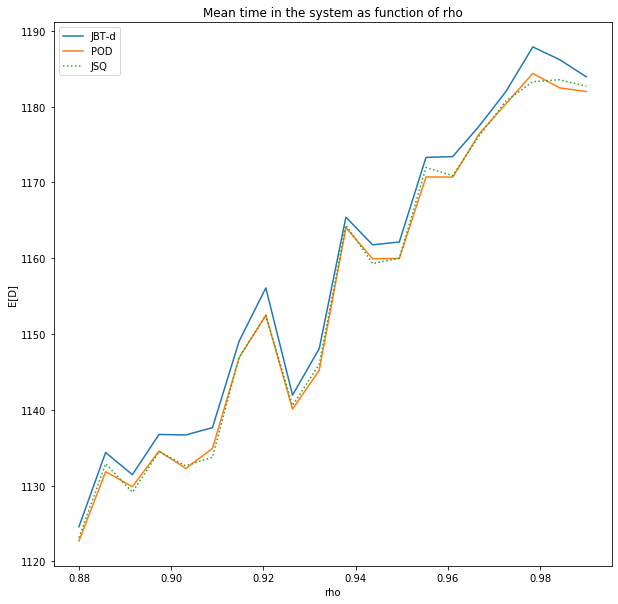

In [9]:
plt.figure(figsize=(10,10))
plt.plot(rhovalues,[i[0] for i in jbtdpoints], label='JBT-d')
plt.plot(rhovalues, [i[0] for i in podpoints], label='POD')
plt.plot(rhovalues, [i[0] for i in jsqpoints], label='JSQ', ls=':')
plt.title('Mean time in the system as function of rho')
plt.xlabel('rho')
plt.legend()
plt.ylabel('E[D]')
plt.show()

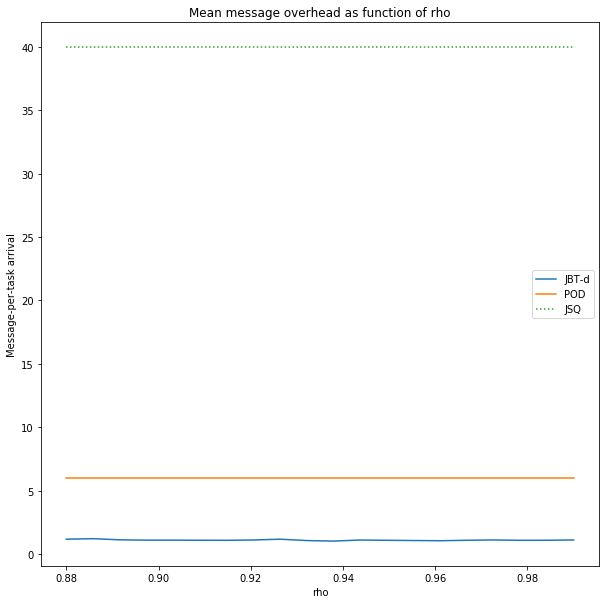

In [11]:
plt.figure(figsize=(10,10))
plt.plot(rhovalues,[i[1] for i in jbtdpoints], label='JBT-d')
plt.plot(rhovalues, [i[1] for i in podpoints], label='POD')
plt.plot(rhovalues, [i[1] for i in jsqpoints], label='JSQ', ls=':')
plt.title('Mean message overhead as function of rho')
plt.xlabel('rho')
plt.legend()
plt.ylabel('Message-per-task arrival')
plt.show()

# My algorithm

In [12]:
def MyAlg(task_arrival, service_times, N=20):
    server= [deque() for i in range(N)]
    memory= [0]*N
    system_time=[]
    overhead=0

    for time, serviceT in zip(task_arrival, service_times):
        for i in range(len(server)):
            if server[i]:
                if server[i][0][0]<time:
                    in_sys=abs(server[i][0][1]-server[i][0][0])
                    server[i].popleft()
                    system_time.append(in_sys)
                    if server[i]:
                        server[i][0][0]+=in_sys

        for i in range(N): 
            memory[i]=len(server[i]) 
            overhead+=2

        #save minimun length queue value
        min_value = min(memory)
        to_choose=[i for i, x in enumerate(memory) if x == min_value]
        #if there are many servers with same min values...
        if len(to_choose)>1 and min_value!=0:            
            ####possible other solution
            #...read the execution times of task in queue...
            to_sum=[[server[ser][time][0] for time in range(len(server[ser]))] for ser in to_choose]
            #..sum the execution times of all task in the queue
            exe_times=[sum(i) for i in to_sum]
            #...and select the server that will be free sooner
            selected_server=to_choose[exe_times.index(min(exe_times))]
            overhead+=len(to_choose)
    
        else:
            #if only a single min len queue server, choose that
            selected_server=np.random.choice(to_choose)

        server[selected_server].append([serviceT+time,time])
        memory[selected_server]+=1
    #HAI CAMBIATO QUI!!    
    return np.mean(system_time), overhead/len(service_times)

In [13]:
MyAlg(np.cumsum(mTv),mXv)

(117616.26882304427, 47.61667)

In [14]:
mypoints=[]
jsqpoints=[]
for i in range(len(rhovalues)):
    mytimes=[]
    jsqtimes=[]
    for j in range(5):
        ntry=10000 #task to generate
        mTv=[]
        mXv=[]

        for k in range(ntry):
            mTv.append(inter_arrival_time(T0,q,Ymed)) 
            EX=EXvalues[i]   
            beta=betavalues[i]
            X=np.maximum(1,np.minimum(100*EX, np.round(beta*(-np.log(runif(0,1)))**(1/alfa))))
            mXv.append(X)
        
        mytimes.append(MyAlg(np.cumsum(mTv),mXv))
        jsqtimes.append(JSQ(np.cumsum(mTv),mXv))
 
    mypoints.append((np.mean([i[0] for i in mytimes]), np.mean([i[1] for i in mytimes])))
    jsqpoints.append((np.mean([i[0] for i in jsqtimes]), np.mean([i[1] for i in jsqtimes])))
    print(f'Execution at {i/len(rhovalues)*100} %')

Execution at 0.0 %
Execution at 5.0 %
Execution at 10.0 %
Execution at 15.0 %
Execution at 20.0 %
Execution at 25.0 %
Execution at 30.0 %
Execution at 35.0 %
Execution at 40.0 %
Execution at 45.0 %
Execution at 50.0 %
Execution at 55.00000000000001 %
Execution at 60.0 %
Execution at 65.0 %
Execution at 70.0 %
Execution at 75.0 %
Execution at 80.0 %
Execution at 85.0 %
Execution at 90.0 %
Execution at 95.0 %


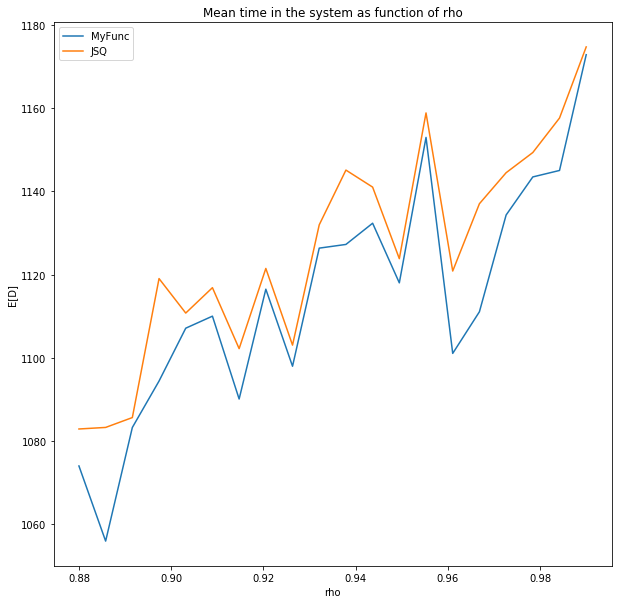

In [15]:
plt.figure(figsize=(10,10))
plt.plot(rhovalues, [i[0] for i in jsqpoints], label='MyFunc')
plt.plot(rhovalues, [i[0] for i in mypoints], label='JSQ')
plt.title('Mean time in the system as function of rho')
plt.xlabel('rho')
plt.legend()
plt.ylabel('E[D]')
plt.show()

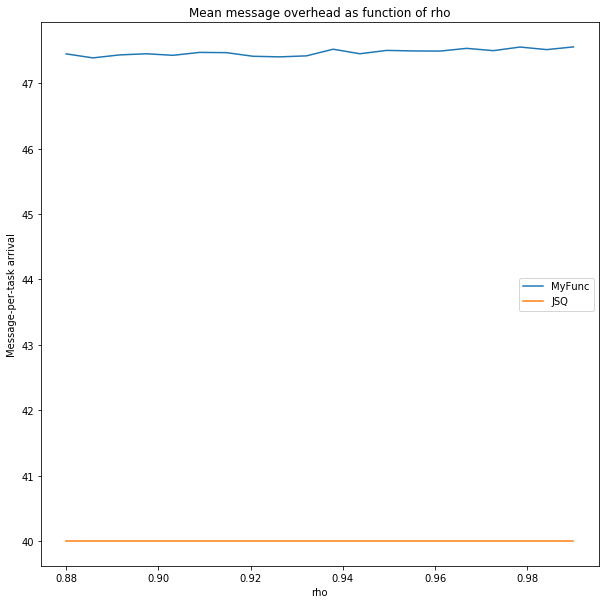

In [16]:
plt.figure(figsize=(10,10))
plt.plot(rhovalues, [i[1] for i in mypoints], label='MyFunc')
plt.plot(rhovalues, [i[1] for i in jsqpoints], label='JSQ')
plt.title('Mean message overhead as function of rho')
plt.xlabel('rho')
plt.legend()
plt.ylabel('Message-per-task arrival')
plt.show()